In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
import cv2

# Image visualization and unpacking 

In this section we are going to read the file from the data and extract the images.

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [3]:
# Carica il train_set (modifica in base alla posizione del tuo file)
train_set = unpickle('tobeignored/train')

# Estrai il nome dei file e i dati delle immagini
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa


images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Crea una classe Dataset personalizzata
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames # nomi delle immagini
        self.images_data = images_data # nomi dei file 
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Carica l'immagine dal dataset
        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # (C, H, W) -> RGB, adatta la forma a seconda del tuo caso

        img = Image.fromarray(np.transpose(img, (1, 2, 0)))  # Cambia l'ordine (H, W, C) a (C, H, W)

        
        if self.transform:
            img = self.transform(img)

        return img, self.filenames[idx]

# Definisci le trasformazioni, ad esempio: ridimensionamento, normalizzazione, ecc.
transform = transforms.Compose([
    transforms.ToTensor()  # Normalizzazione tipica
])


dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle = False)

Filename: bos_taurus_s_000507.png


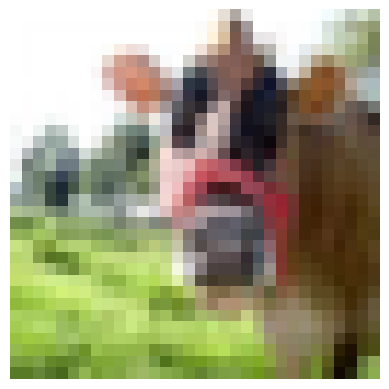

In [4]:
# Funzione per visualizzare un'immagine da un tensor
def imshow(tensor_img, yuv = False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    
    img = tensor_img.numpy()
    
    if yuv == False:
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        plt.imshow(img, cmap = 'jet')
        plt.axis('off')
        plt.show()

# Supponiamo che 'train_loader' sia già definito
# Carica un batch dal train_loader (ad esempio, il primo batch)
for batch in train_loader:
    image_tensor, filename = batch
    image_tensor = batch[0][0]  # La forma è (C, H, W)

    # Visualizza l'immagine
    print(f"Filename: {batch[1][0]}")
    imshow(image_tensor)

    break  # Visualizza solo la prima immagine del primo batch

Filename: bos_taurus_s_000507.png


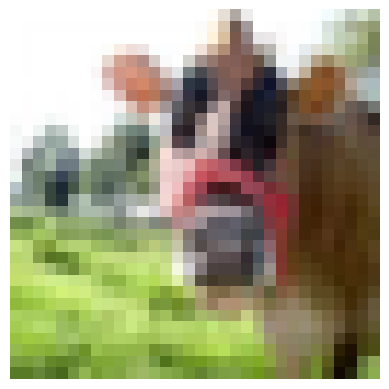

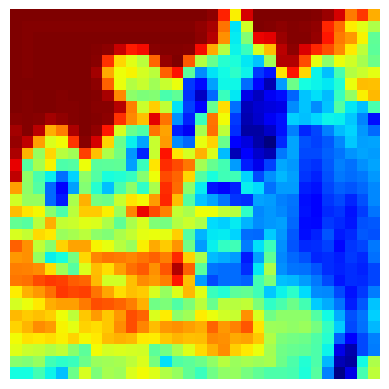

In [5]:
def rgb_to_yuv(image_tensor):
    """
    Converte un'immagine PyTorch tensor (C, H, W) da RGB a YUV usando OpenCV.
    """
    # Converti il tensor in NumPy e permuta gli assi (C, H, W) -> (H, W, C)
    img_np = image_tensor.permute(1, 2, 0).cpu().numpy()

    # Converti da [0,1] (normalizzato da ToTensor) a [0,255]
    img_np = (img_np * 255).astype(np.uint8)

    # Converti da RGB a YUV
    img_yuv = cv2.cvtColor(img_np, cv2.COLOR_RGB2YUV)

    return torch.tensor(img_yuv).permute(2, 0, 1)  # Riporta a (C, H, W)

for batch in train_loader:
    image_tensor, filename = batch  # Estrai dati dal batch

    image_rgb = image_tensor[0]  # Prima immagine del batch (RGB)
    image_yuv = rgb_to_yuv(image_rgb)  # Conversione a YUV

    print(f"Filename: {filename[0]}")
    imshow(image_rgb)
    imshow(image_yuv[0], yuv = True)  # Mostra solo il canale Y (Luminosità)

    break  # Visualizza solo il primo batch



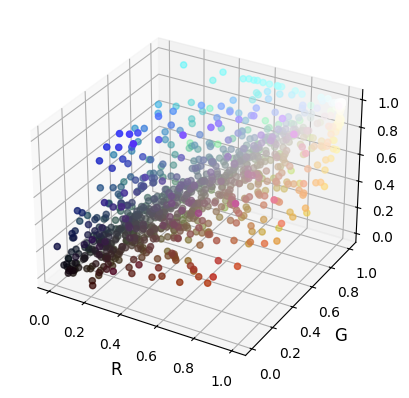

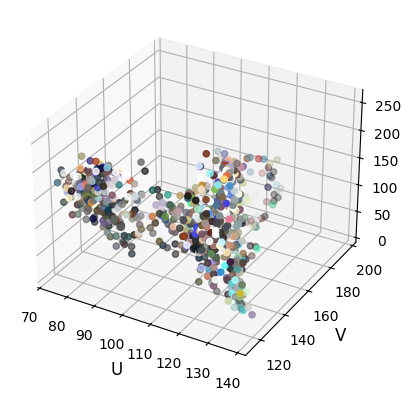

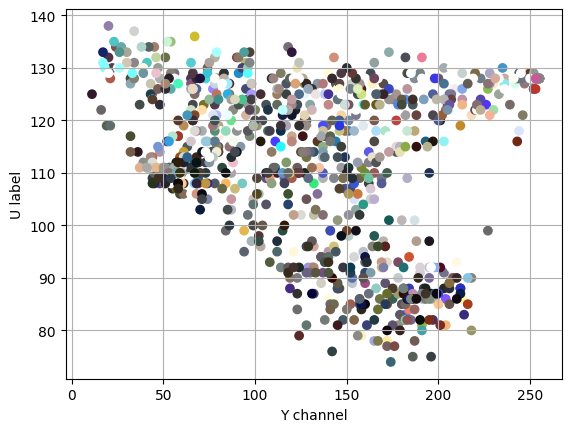

In [6]:
def plot_uv(train_loader, idx = 0):
    num = 0
    for batch in train_loader:
        if num == 1:
            break 
        image_tensor, filename = batch
        
        image_yuv = rgb_to_yuv(image_tensor[0])
        #print(image_tensor[0].shape)
        #image_yuv = cv2.cvtColor(image_tensor[0], cv2.COLOR_RGB2YUV)


        colors = image_tensor[0].reshape(-1, 3) 

        colors_yuv = image_yuv.reshape(-1, 3)

        Y_chan = image_yuv[0, :, :].flatten()
        U_chan = image_yuv[1, :, :].flatten()
        V_chan = image_yuv[2, :, :].flatten()


        
        #print(f"Filename: {filename[0]}")
        #imshow(image_tensor[0])
        ax = plt.axes(projection = '3d')
        ax.scatter(colors[:, 0], colors[:, 1], colors[:, 2], c = colors)
        ax.set_xlabel('R', fontsize=12)
        ax.set_ylabel('G', fontsize=12)
        ax.set_zlabel('B', fontsize=12)
        #plt.scatter(colors[:, 0], colors[:, 1])

        plt.show()
        
        ax = plt.axes(projection = '3d')
        ax.scatter(U_chan, V_chan, Y_chan, c = colors)
        ax.set_xlabel('U', fontsize=12)
        ax.set_ylabel('V', fontsize=12)
        ax.set_zlabel('Y', fontsize=12)
        plt.show()

        
        plt.scatter(Y_chan, U_chan, c = colors)
        plt.xlabel('Y channel')
        plt.ylabel('U label')
        plt.grid()


        
        num += 1
plot_uv(train_loader)

# CNN construction

In this first section we are going to construct the structure encoder <-> decoder of the network. 
The network works as following:
since our task is image colorization, we want to predict the `UV` channels given a grayscale image.
1. Input (grayscale image): we want to pass the grayscale channel `Y` to the network;
2. Target (color image): the target should contain the full color image, i.e. the `YUV` image.

In [ ]:
# Creating a new Dataset class in order to extract the images (both RGB and YUV)
'''
class CustomDataset(Dataset):
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames  # Names of the images
        self.images_data = images_data  # Images (in RGB or YUV format)
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get image data (RGB image) from the dataset
        img_data = self.images_data[idx]
        
        img_rgb = np.array(img_data, dtype=np.uint8).reshape(3, 32, 32)  # Assuming RGB
        img_rgb = np.transpose(img_rgb, (1, 2, 0))  
        
        # Convert the image from RGB to YUV
        img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
        
        # Extract Y channel as input (grayscale)
        img_y = img_yuv[:, :, 0]  # Y channel (luminance)
        
        # Extract UV channels as target (chrominance)
        img_uv = img_yuv[:, :, 1:]  # U and V channels (chrominance)
        
        # Convert Y to 1 channel image (grayscale)
        #img_y = np.expand_dims(img_y, axis=-1)  # Add channel dimension (H, W) -> (H, W, 1)ù

        img_y = Image.fromarray(img_y.astype(np.uint8))
        img_uv = Image.fromarray(img_uv.astype(np.uint8))

        # Apply any transformations if provided
        if self.transform:
            img_y = self.transform(img_y)  # Grayscale input image
            img_uv = self.transform(img_uv)  # UV channels as output
            img_rgb = self.transform(img_rgb)


        return img_rgb, img_y, img_uv
    
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    #transforms.Normalize(mean=[0.485], std=[0.229])  # Normalize for grayscale input
])

train_set = unpickle('tobeignored/train')
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]  # Decodifica da byte a stringa
images_data = train_set[b'data']  # Supponiamo che le immagini siano in un array NumPy

# Create dataset
dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=False)

'''

In [7]:
# Funzione per visualizzare un'immagine da un tensor
def imshow(tensor_img, yuv=False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    img = tensor_img.numpy()

    if not yuv:
        # Per immagini RGB
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        # Se yuv è True, separa i canali Y, U, V e visualizzali separatamente
        # Controlla se l'immagine ha 3 canali
        if img.shape[0] == 3:  # (Y, U, V) -> (C, H, W)
            y_channel = img[0]  # Canale Y
            u_channel = img[1]  # Canale U
            v_channel = img[2]  # Canale V

            # Visualizza il canale Y in scala di grigi
            plt.imshow(y_channel, cmap='gray')
            plt.title('Y Channel')
            plt.axis('off')
            plt.show()

            # Visualizza il canale U con una mappa di colori
            plt.imshow(u_channel, cmap='jet')
            plt.title('U Channel')
            plt.axis('off')
            plt.show()

            # Visualizza il canale V con una mappa di colori
            plt.imshow(v_channel, cmap='jet')
            plt.title('V Channel')
            plt.axis('off')
            plt.show()
        
        else:
            print("L'immagine YUV non ha 3 canali. Verifica la forma dell'immagine.")

# Regression based CNN

In [55]:
# ----- DATASET -----
# We should use the transformed yuv dataset instead of this one 

class YUVImageDataset(Dataset):
    '''
    This class takes in input the whole dataset in YUV format and outputs it in order to be 
    analyzed by the network, such that the output is Y and (U, V)
    '''
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames
        self.images_data = images_data 
        self.transform = transform

    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, idx):
        img_data = self.images_data[idx]

        img_data = self.images_data[idx]
        img = np.array(img_data, dtype=np.uint8)

        Y_channel = img[0:1024].reshape(32, 32, 1) / 255
        U_channel = img[1024:2048].reshape(32, 32, 1) / 255
        V_channel = img[2048:].reshape(32, 32, 1) / 255

        target = np.concatenate([U_channel, V_channel], axis=2)  

        Y_channel = torch.tensor(Y_channel, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        return Y_channel, target
        

### and run this class only to load the data

In [71]:
# ----- CNN MODEL -----
class YUVColorizationNet(nn.Module):
    '''
    The CNN takes in input the Y channel and tries to predict the U and V channels 
    '''
    def __init__(self):
        super(YUVColorizationNet, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample (H, W) -> (H/2, W/2)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Downsample (H/4, W/4)
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
             nn.Conv2d(128, 64, kernel_size=3, padding=1),
             nn.ReLU(),
             nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Upsample a (16,16)
             nn.ReLU(),
             nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),  # Upsample a (32,32)
             nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # Output shape: (batch_size, 2, H, W)


In [57]:
# Loss function 
# First compute the cosine as u * v / |u||v|
# u * v = costheta |u||v|
# from theta = arccos(cos(theta)) = arccos(u*v/|u||v|)
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, predictions, targets):
        # Uncomment to use tanh activation function
        #targets = (targets * 2) - 1 # check if the values outside the func are changing 
        dot_prod = (predictions * targets).sum(dim = 0) # output has dim [1, 8192]
        norm = torch.norm(predictions, dim = 0) * torch.norm(targets, dim = 0) # it's a scalar
        cos_sim = dot_prod / (norm + 1e-8)  # Avoid division by zero
        cos_sim = torch.clamp(cos_sim, -1 + 1e-7, 1 - 1e-7)  # Clamp for numerical stability

        theta = torch.acos(cos_sim) # result is already in radians 

        loss = theta.sum()
        return loss

### Use from here

In [58]:
def yuv_rgb(array):
    new_array = array.numpy().astype(np.float32).copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    return torch.tensor((new_array*255).astype(np.uint8)).permute(2, 0, 1)

In [59]:
def imshow(tensor_img, cmap=None, yuv = False):
    # Converti il tensor da (C, H, W) a (H, W, C) per matplotlib
    
    img = tensor_img.numpy()
    
    if yuv == False:
        img = tensor_img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
        plt.imshow(img)
        plt.axis('off')  # Nasconde gli assi
        plt.show()

    else:
        plt.imshow(img, cmap = cmap)
        plt.axis('off')
        plt.show()

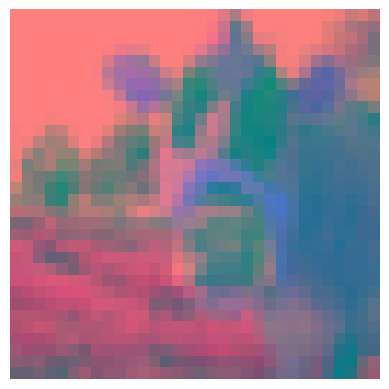

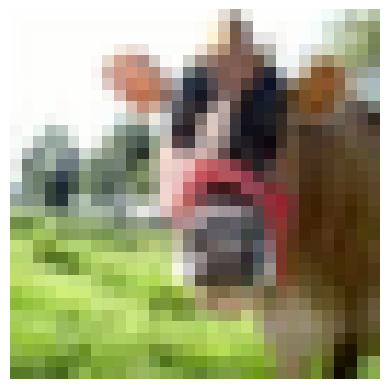

In [60]:
train_set = unpickle('tobeignored/yuv_train') # we use yuv train images for training
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]
images_data = train_set[b'data']

dataset = YUVImageDataset(filenames = filenames, images_data = images_data)
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

for Y_channel, target in train_loader:
    
    img_batch = torch.cat([Y_channel,target],dim=3).permute(0,3,1,2)

    imggg = img_batch[0]
    imshow(imggg)
    rgb_output = yuv_rgb(imggg.permute(1,2,0))

    imshow(rgb_output)
    break

### to here

In [73]:

# ----- RUN ONLY DURING TRAINING -----
train_set = unpickle('tobeignored/yuv_train') # we use yuv train images for training
filenames = [f.decode('utf-8') for f in train_set[b'filenames']]
images_data = train_set[b'data']

dataset = YUVImageDataset(filenames = filenames, images_data = images_data, transform = transform )
train_loader = DataLoader(dataset, batch_size=8, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNet().to(device)

#criterion = nn.MSELoss()  # L2 Loss (U and V are continuous)
criterion = CustomLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for Y_channel, target in train_loader:
        Y_channel = Y_channel.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)

        Y_channel = Y_channel.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(Y_channel)

        output, target = output.permute(1, 0, 2, 3), target.permute(1, 0, 2, 3) # permuting in order to flatten dimensions
        output, target = output.reshape(2, -1), target.reshape(2, -1)

        loss = criterion(output, target) # flattening the dimensions
        loss.backward(retain_graph = True)
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Save Model
torch.save(model.state_dict(), "yuv_colorization_model.pth")

Epoch [1/100], Loss: 698.8376
Epoch [2/100], Loss: 681.0406
Epoch [3/100], Loss: 674.3473
Epoch [4/100], Loss: 669.5999
Epoch [5/100], Loss: 666.2227
Epoch [6/100], Loss: 663.0093
Epoch [7/100], Loss: 660.4672
Epoch [8/100], Loss: 658.2854
Epoch [9/100], Loss: 656.0137
Epoch [10/100], Loss: 653.6617
Epoch [11/100], Loss: 651.8698
Epoch [12/100], Loss: 649.8495
Epoch [13/100], Loss: 648.0871
Epoch [14/100], Loss: 646.6404
Epoch [15/100], Loss: 644.8758
Epoch [16/100], Loss: 643.3320
Epoch [17/100], Loss: 641.8149
Epoch [18/100], Loss: 640.5720
Epoch [19/100], Loss: 639.2684
Epoch [20/100], Loss: 638.2145
Epoch [21/100], Loss: 636.9540
Epoch [22/100], Loss: 635.9087
Epoch [23/100], Loss: 635.0294
Epoch [24/100], Loss: 633.9876
Epoch [25/100], Loss: 632.9648
Epoch [26/100], Loss: 631.9410
Epoch [27/100], Loss: 630.9789
Epoch [28/100], Loss: 630.0891
Epoch [29/100], Loss: 629.3152
Epoch [30/100], Loss: 628.4502
Epoch [31/100], Loss: 627.6977
Epoch [32/100], Loss: 626.9668
Epoch [33/100], L

C:\Users\adadi\AppData\Local\Temp\ipykernel_34288\1043699282.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("yuv_colorization_model.pth

torch.Size([1, 1, 32, 32])
ORIGINAL IMAGE RANGE (-0.0011921518, 1.002549)
YUV image range: (9, 255)
Colorized image range: (0.0, 1.0)


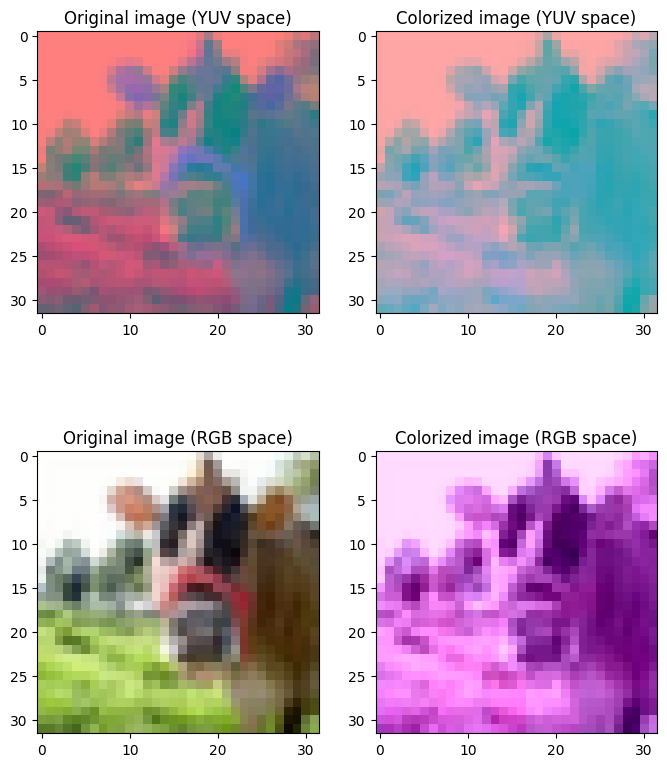

torch.Size([1, 1, 32, 32])
ORIGINAL IMAGE RANGE (0.13581178, 1.0019137)
YUV image range: (57, 255)
Colorized image range: (0.02745098, 1.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.13581178..1.0019137].


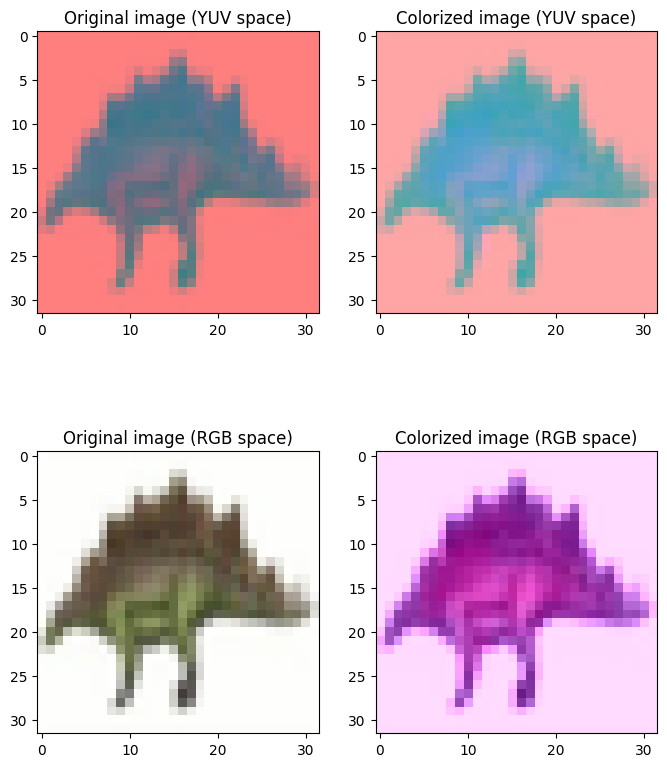

torch.Size([1, 1, 32, 32])
ORIGINAL IMAGE RANGE (0.08040785, 0.98850197)
YUV image range: (51, 254)
Colorized image range: (0.0, 1.0)


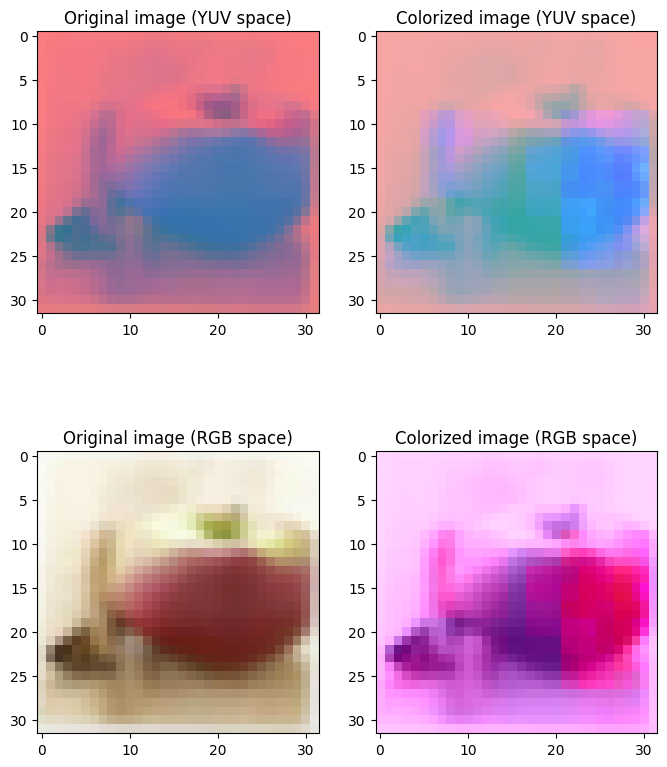

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007254901..0.9966].


torch.Size([1, 1, 32, 32])
ORIGINAL IMAGE RANGE (-0.007254901, 0.9966)
YUV image range: (1, 249)
Colorized image range: (0.0, 1.0)


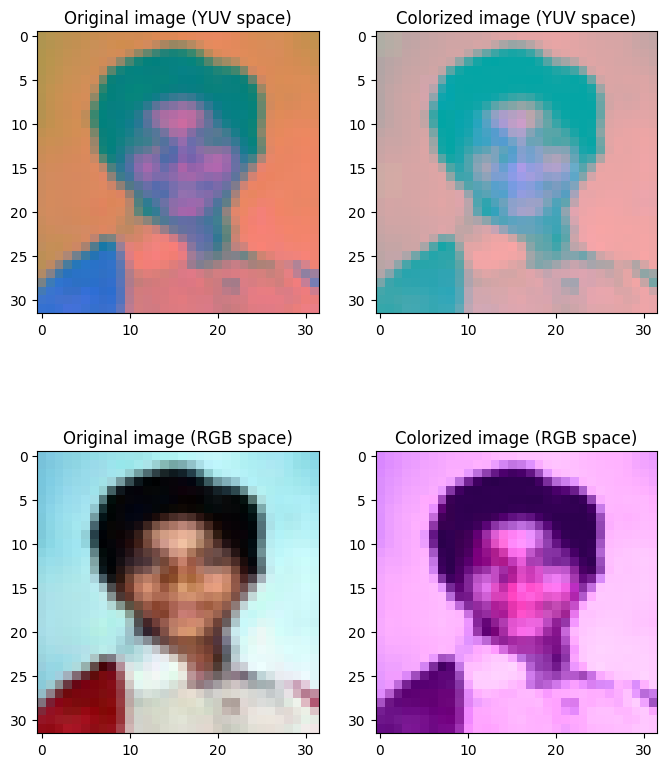

In [ ]:
# maybe some skip connection can improve the performances 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNet().to(device)
model.load_state_dict(torch.load("yuv_colorization_model.pth"))

dataset = YUVImageDataset(filenames = filenames, images_data = images_data, transform = transform )

org_dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
org_train =  DataLoader(org_dataset, batch_size=32, shuffle = False)

def colorize_image(model, y_channel):
    model.eval()
    
    # Ensure y_channel is in the correct format: [batch, 1, H, W]
    y_channel = y_channel.clone().detach().to(torch.float32).to(device)  
    if y_channel.dim() == 3:  
        y_channel = y_channel.unsqueeze(0)  # Add batch dim only if needed
    
    with torch.no_grad():
        uv_pred = model(y_channel).cpu().squeeze(0)  # Remove batch dim
    
    return uv_pred.numpy()


# Let's try to visualize some outputs of the networks
n_out = 4
for batch in org_train:
    for i in range(n_out):
        # Load a grayscale Y channel image and predict colorization
        y_input = dataset[i][0].unsqueeze(0)  # Example input (1, H, W)
        y_input = y_input.permute(0, 3, 1, 2)
        uv_output = colorize_image(model, y_input)  # Given the Y input, the algorithm should be able of predicting the UV colors
        # Convert back to RGB

        u = uv_output[0] 
        v = uv_output[1] 
  
        #yuv_image = np.concatenate([y_input[0, :, :, :], uv_output[0:1, :, :]], axis=0)  # (3, H, W)
        yuv_image = np.stack([y_input[0, 0, :, :], u, v], axis=-1)

        #yuv_image = np.transpose(yuv_image, (1, 2, 0))  # Convert to (H, W, 3) to use cv2
        # Also values should be multiplied by 255 for conversion to RGB range

        yuv_image = (yuv_image * 255).astype(np.uint8)
        #yuv_image = np.abs(yuv_image)
        rgb_colorized = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)
        rgb_colorized = rgb_colorized.astype(np.float32) / 255
        #bgr_colorized = cv2.cvtColor(rgb_colorized, cv2.COLOR_BGR2RGB)
 
        image_tensor, _ = batch  # Estrai dati dal batch

        org_rgb = image_tensor[i, :, :, :]  # First batch image 

        yuv_org = np.transpose(org_rgb, (1, 2, 0))
        yuv_org = np.array(yuv_org)
        org_rgb = cv2.cvtColor(yuv_org, cv2.COLOR_YUV2RGB)

        print(f'ORIGINAL IMAGE RANGE {org_rgb.min(), org_rgb.max()}')
        print(f'YUV image range: {yuv_image.min(), yuv_image.max()}')
        print(f'Colorized image range: {rgb_colorized.min(), rgb_colorized.max()}')
        
        plt.figure(figsize = (8,10))
        #plt.subplot(1, 4, 1)
        #plt.imshow(y_input[0, :, :, :].permute(1, 2, 0), cmap = 'gray')
        #plt.title('Training image')

        plt.subplot(2, 2, 1)
        plt.imshow(yuv_org)
        plt.title('Original image (YUV space)')
        

        plt.subplot(2, 2, 2)
        plt.imshow(yuv_image)
        plt.title("Colorized image (YUV space)")

        plt.subplot(2, 2, 3)
        plt.imshow(org_rgb)
        plt.title('Original image (RGB space)')

        plt.subplot(2, 2, 4)
        plt.imshow(rgb_colorized)
        plt.title("Colorized image (RGB space)")

        # ----------------- Hystogram plots ------------------------
        '''
        plt.figure(figsize = (10, 10))
        plt.subplot(2, 2, 1)
        plt.hist(image_yuv[1].flatten(), bins = 50, color = 'blue', alpha = 0.7)
        plt.xlim(50, 200)
        plt.title("U Histogram (Original)")


        plt.subplot(2, 2, 2)
        plt.hist(image_yuv[2].flatten(), bins=50, color='red', alpha=0.7)
        plt.xlim(50, 200)
        plt.title("V Histogram (Original)")

        plt.subplot(2, 2, 3)
        plt.hist(yuv_image[:, :, 1].flatten() * 255, bins=50, color='blue', alpha=0.7)
        plt.xlim(50, 200)
        plt.title("U Histogram (Predicted)")

        plt.subplot(2, 2, 4)
        plt.hist(yuv_image[:, :, 2].flatten() * 255, bins=50, color='red', alpha=0.7)
        plt.xlim(50, 200)
        plt.title("V Histogram (Predicted)")

        plt.tight_layout()
        '''
        plt.show()



        
    break 


If the U values are low and V values are high, we can get a more pinkish tone.

## CNN Regression improvement 

In the next section we are trying to implement a different structure for our model: the network will first try to get the correct u value and then the updated model will be used to train for the v value.


In [78]:
# ----- DATASET -----

class YUVImageDataset_mod2(Dataset):
    '''
    This class takes in input the whole dataset and prepares it for training
    by loading images, converting them to YUV format and normalizing the channels
    The target is a vector formed by U and V values, used to compute the loss 
    In this case the target will be formed by the U channel only
    '''
    def __init__(self, filenames, images_data, transform=None):
        self.filenames = filenames
        self.images_data = images_data 
        self.transform = transform

    def __len__(self):
        return len(self.images_data)

    def __getitem__(self, idx):
        img_data = self.images_data[idx]

        img = np.array(img_data, dtype=np.uint8)  # Assuming RGB: the images that we read are in the RGB forma

        Y_channel = (img[0:1024].reshape(32, 32, 1) / 255).astype(np.float32)
        U_channel = (img[1024:2048].reshape(32, 32, 1) / 255).astype(np.float32)
        V_channel = (img[2048:].reshape(32, 32, 1) / 255).astype(np.float32)
        
        
        # Add channel dimension (H, W) -> (1, H, W)
        Y_channel = np.expand_dims(Y_channel, axis=0)  
        U_channel = np.expand_dims(U_channel, axis=0)
        V_channel = np.expand_dims(V_channel, axis=0)


        # Convert to tensors
        Y_channel = torch.tensor(Y_channel, dtype=torch.float32)
        u_target = torch.tensor(U_channel , dtype=torch.float32)
        v_target = torch.tensor(V_channel, dtype = torch.float32)

        return Y_channel, u_target, v_target 
    

In [79]:
class Phase1Network(nn.Module):
    def __init__(self):
        super(Phase1Network, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample (H/2, W/2)
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # Downsample (H/4, W/4)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        u_channel = self.decoder(x)
        return u_channel

class Phase2Network(nn.Module):
    def __init__(self):
        super(Phase2Network, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        v_channel = self.decoder(x)
        return v_channel

class YUVColorizationNetwork(nn.Module):
    def __init__(self):
        super(YUVColorizationNetwork, self).__init__()
        self.phase1 = Phase1Network()  # For predicting U
        self.phase2 = Phase2Network()  # For predicting V

    def forward(self, y):
        u = self.phase1(y)  # Predict U channel from Y
        v = self.phase2(y)  # Predict V channel from Y 
        return u, v

In [90]:
## ---------------------------- RUN ONLY DURING TRAINING ----------------------------------------------


# Define the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNetwork().to(device)
#model = YUVColorizationNetwork()

optimizer_u = optim.Adam(model.parameters(), lr=0.001)
optimizer_v = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.MSELoss()

# Assuming you have the filenames and images_data ready
train_dataset = YUVImageDataset_mod2(filenames, images_data)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training Loop
num_epochs = 50  # Adjust the number of epochs based on your needs
for epoch in range(num_epochs):
    for batch in train_loader:
        # Get Y input and U target from the dataset
        y_input, u_target, v_target = batch  # y_input is the Y channel, u_target is the U channel

        y_input = y_input.permute(0, 1, 4, 2, 3).squeeze(2)

        y_input = y_input.to(device)
        u_target = u_target.to(device)
        v_target = v_target.to(device)
        

        # ---------------------- Predicting u ------------------------------------
        optimizer_u.zero_grad()
        u_pred, _ = model(y_input) #ignoring the v prediction  

        # Compute loss for U and V channels
        loss_u = criterion(u_pred, u_target)
        loss_u.backward()
        optimizer_u.step() 

        # ----------------- Predicting v ---------------------
        optimizer_v.zero_grad()
        _, v_pred = model(y_input)
        loss_v = criterion(v_pred, v_target)  # You can compute V loss too if you have ground truth for V
        loss_v.backward()
        optimizer_v.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], \n Loss for u: {loss_u.item():.4f}, \n Los for v: {loss_v.item():.4f} \n ----------------------------------------z-")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YUVColorizationNetwork().to(device)
torch.save(model.state_dict(), 'tobeignored/two_phase_model.pth')

c:\ProgramData\anaconda3\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([16, 1, 32, 32, 1])) that is different to the input size (torch.Size([16, 1, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], 
 Loss for u: 0.0039, 
 Los for v: 0.0103 
 ----------------------------------------z-
Epoch [2/50], 
 Loss for u: 0.0026, 
 Los for v: 0.0102 
 ----------------------------------------z-
Epoch [3/50], 
 Loss for u: 0.0050, 
 Los for v: 0.0058 
 ----------------------------------------z-
Epoch [4/50], 
 Loss for u: 0.0082, 
 Los for v: 0.0126 
 ----------------------------------------z-
Epoch [5/50], 
 Loss for u: 0.0054, 
 Los for v: 0.0120 
 ----------------------------------------z-
Epoch [6/50], 
 Loss for u: 0.0028, 
 Los for v: 0.0038 
 ----------------------------------------z-
Epoch [7/50], 
 Loss for u: 0.0023, 
 Los for v: 0.0040 
 ----------------------------------------z-
Epoch [8/50], 
 Loss for u: 0.0022, 
 Los for v: 0.0110 
 ----------------------------------------z-
Epoch [9/50], 
 Loss for u: 0.0035, 
 Los for v: 0.0131 
 ----------------------------------------z-
Epoch [10/50], 
 Loss for u: 0.0040, 
 Los for v: 0.0037 
 --------------------------------

KeyboardInterrupt: 

In [52]:
model.load_state_dict(torch.load("tobeignored/two_phase_model.pth"))

dataset = YUVImageDataset_mod2(filenames = filenames, images_data = images_data, transform = transform )

org_dataset = CustomDataset(filenames=filenames, images_data=images_data, transform=transform)
org_train =  DataLoader(org_dataset, batch_size=32, shuffle = False)

C:\Users\adadi\AppData\Local\Temp\ipykernel_34288\1149194009.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("tobeignored/two_phase_mode

In [53]:
def yuv_to_rgb(yuv_image):
    y = yuv_image[:, :, 0]
    u = yuv_image[:, :, 1]
    v = yuv_image[:, :, 2]

    rgb_image = np.zeros(yuv_image.shape)
    rgb_image[:, :, 0] = 1.164 * (y - 16) + 1.596 * (v - 128)
    rgb_image[:, :, 1] = 1.164 * ( y - 16) - 0.813 * (v - 128) - 0.391 * (u - 128)
    rgb_image[:, :, 2] = 1.164 * (y - 16) + 2.018 * (u - 128)

    return rgb_image 

In [54]:
def colorize_image_2(model, y_input, device='cuda'):
    """
    Colorizes an image using the trained model. 
    y_input is the Y channel of the grayscale image.
    
    Parameters:
    - model: The trained model
    - y_input: Grayscale Y channel image (1, H, W)
    - device: The device to use for prediction ('cuda' or 'cpu')
    
    Returns:
    - colorized_image: The colorized RGB image
    """
    model.to(device)
    model.eval()  # Set the model to evaluation mode
    
    # Ensure the input is on the same device as the model
    y_input = y_input.to(device)
    
    with torch.no_grad():  # Disable gradient tracking for inference
        u_pred, v_pred = model(y_input)  # Predict the U and V channels
    
    # Convert predictions to numpy arrays (if they are on GPU, move them to CPU first)
    u_pred = u_pred.cpu().numpy().squeeze(0)  # Remove batch dimension
    v_pred = v_pred.cpu().numpy().squeeze(0)  # Remove batch dimension
    
    # Rescale U and V channels from [0, 1] back to [0, 255]
    
    u_pred = np.clip(u_pred * 255, 0, 255) #.astype(np.uint8)
    v_pred = np.clip(v_pred * 255, 0, 255)  #.astype(np.uint8)

    # Combine the Y, U, and V channels into one YUV image
    yuv_image = np.stack([y_input.cpu().numpy().squeeze(0) * 255, u_pred, v_pred], axis=-1)

    
    return yuv_image

n_out = 4
for batch in org_train:
    for i in range(n_out):
        # Load a grayscale Y channel image and predict colorization
        y_input = dataset[i][0].unsqueeze(0)  # Example input (1, H, W)
        
        yuv_output = colorize_image_2(model, y_input)  # Given the Y input, the algorithm should be able of predicting the UV colors


        # Convert the YUV image back to RGB
        rgb_output = cv2.cvtColor(yuv_output[0], cv2.COLOR_YUV2RGB)

        # Convert back to RGB
        
        image_tensor, _ = batch  # Estrai dati dal batch

        org_rgb = image_tensor[i, :, :, :]  # First batch image 
        image_yuv = rgb_to_yuv(org_rgb)       
        yuv_output = yuv_output[0]
    
        org_rgb = np.transpose(org_rgb, (1, 2, 0))


        rgb_output_1 = cv2.cvtColor(yuv_output, cv2.COLOR_YUV2RGB)
        rgb_output = yuv_to_rgb(yuv_output)

        #print(rgb_output)

        plt.figure(figsize = (10,5))
        plt.subplot(1, 5, 1)
        plt.imshow(image_yuv[0], cmap = 'gray')
        plt.title('Training image')

        plt.subplot(1, 5, 2)
        plt.imshow(org_rgb)
        plt.title('Original image')
        
        plt.subplot(1, 5, 3)
        plt.imshow(yuv_output[:, :, 0] , cmap = 'gray')
        plt.title("Y channel")


        # Canale Y
        plt.subplot(1, 5, 4)
        plt.imshow(yuv_output[:, :, 1] , cmap='jet')  
        plt.title('U Channel')
        plt.axis('off')

        # Canale U
        plt.subplot(1, 5, 5)
        plt.imshow(yuv_output[:, :, 2] , cmap = 'jet') 
        plt.title('V Channel')
        plt.axis('off')

        plt.show()
        plt.imshow(rgb_output_1 / 255)

        plt.show()

    break 


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 32, 32, 1]